# Customer Exit Prediction Model
  
This Project aims to predict whether a customer of a financial institution exits or stays by addressing a classification problem, involving steps such as Exploratory Data Analysis (EDA), feature engineering, data preprocessing, model training and tuning, and generating a kaggle submission file.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv
/kaggle/input/plot-images/Parallel_Plot.png
/kaggle/input/plot-images/Donut_Plot.png
/kaggle/input/plot-images/TreeMap_Plot.png


# 1. Importing Libraries

We Begin the process by importing all the necessary libraries

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import warnings

# 2. Loading Files
  
* Loading the datasets into pandas DataFrames.
  
* train.csv: training data along with target variable (price).
  
* test.csv: test data with price
  
* sample_submission.csv: file showing the format for kaggle submission.

In [3]:
warnings.filterwarnings('ignore')

submission_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv')

train_df.head()

,id,customer_id,last_name,credit_score,country,gender,age,tenure,acc_balance,prod_count,has_card,is_active,estimated_salary,exit_status
0,0,15788291,Iredale,559.0,France,Male,28.0,1,149989.39,1.0,1.0,1.0,67622.46,0
1,1,15642816,Hs?,694.0,France,Female,37.0,7,114510.35,2.0,0.0,0.0,182797.86,0
2,2,15632272,T'ien,585.0,NaN,Female,45.0,8,NaN,2.0,1.0,1.0,170338.35,0
3,3,15685826,Hightower,589.0,Spain,Male,25.0,0,166082.18,1.0,1.0,1.0,166476.46,0
4,4,15658032,Hopkins,701.0,France,Male,39.0,2,0.00,2.0,1.0,0.0,82526.92,0


# 3. Data Preprocessing

Understanding the dataset

## 3.1 Identifying the data types of the columns

Indentifying the data types of columns helps us in differentiating different type of features like datetime, numerical and categorical.

In [4]:
train_df.dtypes

id                    int64
customer_id           int64
last_name            object
credit_score        float64
country              object
gender               object
age                 float64
tenure                int64
acc_balance         float64
prod_count          float64
has_card            float64
is_active           float64
estimated_salary    float64
exit_status           int64
dtype: object

## 3.2 Descriptive Statistics

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,90000.0,4.499950e+04,25980.906451,0.00,22499.75,44999.50,6.749925e+04,89999.00
customer_id,90000.0,1.569209e+07,71297.959941,15565701.00,15633608.00,15690164.00,1.575674e+07,15815690.00
credit_score,80444.0,6.564971e+02,80.016856,350.00,597.00,659.00,7.100000e+02,850.00
age,90000.0,3.811953e+01,8.855203,18.00,32.00,37.00,4.200000e+01,92.00
tenure,90000.0,5.017022e+00,2.804813,0.00,3.00,5.00,7.000000e+00,10.00
acc_balance,82743.0,5.545673e+04,62788.474236,0.00,0.00,0.00,1.198258e+05,250898.09
prod_count,85137.0,1.552932e+00,0.548011,1.00,1.00,2.00,2.000000e+00,4.00
has_card,90000.0,7.542889e-01,0.430510,0.00,1.00,1.00,1.000000e+00,1.00
is_active,90000.0,4.971778e-01,0.499995,0.00,0.00,0.00,1.000000e+00,1.00
estimated_salary,90000.0,1.123947e+05,50360.440702,11.58,74430.36,117505.07,1.548748e+05,199992.48


# 4. Data Cleaning

## 4.1 Identifying and Handling Missing Values
  
In most cases, we need a complete dataset i.e., dataset without any missing values to get accurate results. Based on the importance of the data we either remove the affected rows/columns or use statistical methods to impute the missing values.

In [6]:
#Identifying Missing Values
print('Missing values in train dataset:\n', train_df.isnull().sum())
print('\n')
print('Missing values in test dataset:\n', test_df.isnull().sum())

Missing values in train dataset:
 id                     0
customer_id            0
last_name              0
credit_score        9556
country             6021
gender                 0
age                    0
tenure                 0
acc_balance         7257
prod_count          4863
has_card               0
is_active              0
estimated_salary       0
exit_status            0
dtype: int64


Missing values in test dataset:
 id                     0
customer_id            0
last_name              0
credit_score        3185
country             4606
gender                 0
age                    0
tenure                 0
acc_balance         5251
prod_count          1717
has_card               0
is_active              0
estimated_salary       0
dtype: int64


In [7]:
#Handling Missing Values

for col in ['customer_id', 'credit_score', 'age', 'acc_balance', 'prod_count', 'has_card', 'is_active', 'estimated_salary']:
    train_df[col].fillna(train_df[col].mean(), inplace=True)
    test_df[col].fillna(test_df[col].mean(), inplace=True)

for col in ['last_name', 'country', 'gender']:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)

train_df['exit_status'] = pd.to_numeric(train_df['exit_status'], errors='coerce')
train_df = train_df.dropna(subset=['exit_status'])

print('After Imputation\n')
print('Training dataset missing values:', train_df.isnull().sum().sum())
print('Test dataset missing values:', test_df.isnull().sum().sum())

After Imputation

Training dataset missing values: 0
Test dataset missing values: 0


## 4.2 Handling Duplicates

Identifying and removing duplicate entries in training dataset.

In [8]:
train_ids = train_df['id']
test_ids = test_df['id']

train_features = train_df.drop(columns=['id'])
test_features = test_df.drop(columns=['id'])

print(f"Initial training set shape (features only): {train_features.shape}")
num_train_duplicates = train_features.duplicated().sum()
print(f"Found {num_train_duplicates} feature-based duplicate rows in the training set.")

if num_train_duplicates > 0:
    duplicate_indices = train_features[train_features.duplicated()].index
    train_features.drop(index=duplicate_indices, inplace=True)
    train_df.drop(index=duplicate_indices, inplace=True) 
    print("Feature-based duplicates have been removed from the training set.")
    print(f"Final training set shape: {train_df.shape}\n")
else:
    print("No feature-based duplicates to remove in the training set.\n")

print(f"Test set shape (features only): {test_features.shape}")
num_test_duplicates = test_features.duplicated().sum()
print(f"Found {num_test_duplicates} feature-based duplicate rows in the test set.")
print("Note: As before, these are NOT removed from the test set.\n")

print('Training dataset:', train_df.shape)
print('Test dataset:', test_df.shape)

Initial training set shape (features only): (90000, 13)
Found 2 feature-based duplicate rows in the training set.
Feature-based duplicates have been removed from the training set.
Final training set shape: (89998, 14)

Test set shape (features only): (30000, 12)
Found 0 feature-based duplicate rows in the test set.
Note: As before, these are NOT removed from the test set.

Training dataset: (89998, 14)
Test dataset: (30000, 13)


## 4.3 Identifying and Handling Outliers
  
Data points which significantly differ from rest of the dataset are known as Outliers. Outliers can distort the performance of the model. We handle them using the InterQuartile Range(IQR) techinique.

Processing column: credit_score
Number of outliers found in 'credit_score': 605


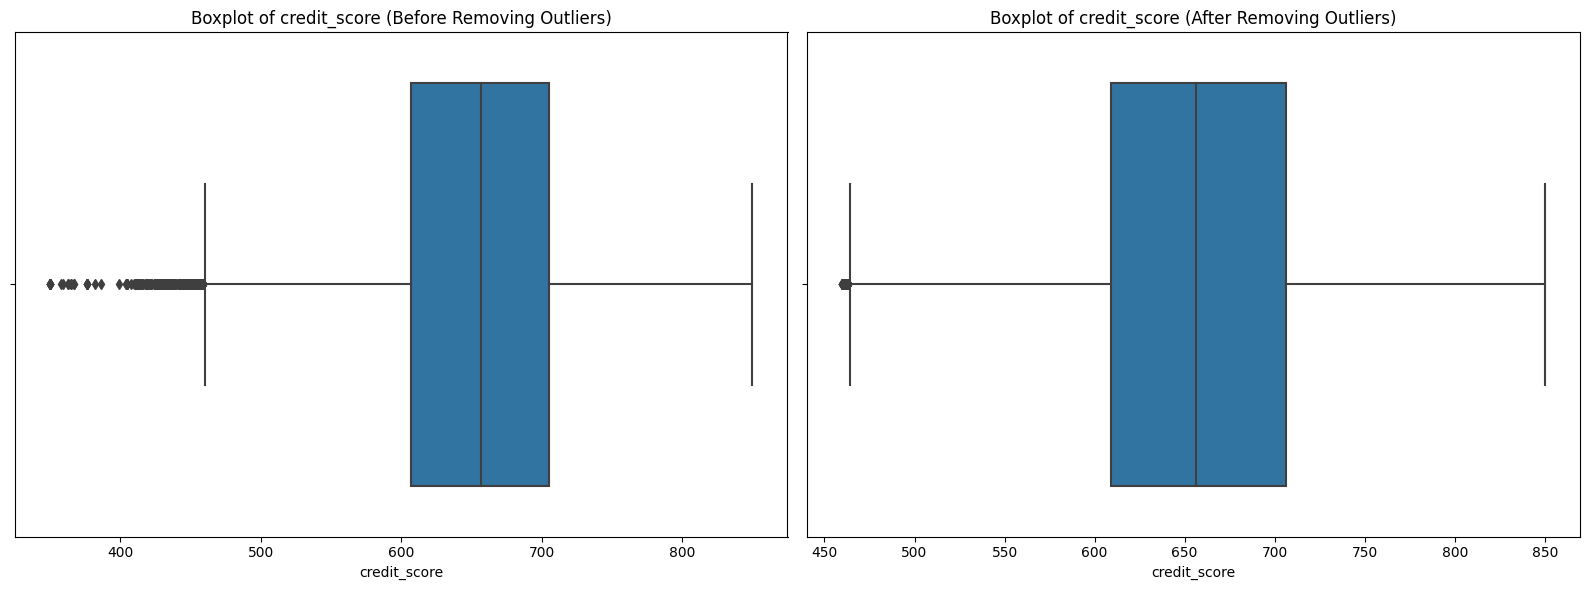

Saved plot to credit_score_outlier_comparison.png

Processing column: age
Number of outliers found in 'age': 3411


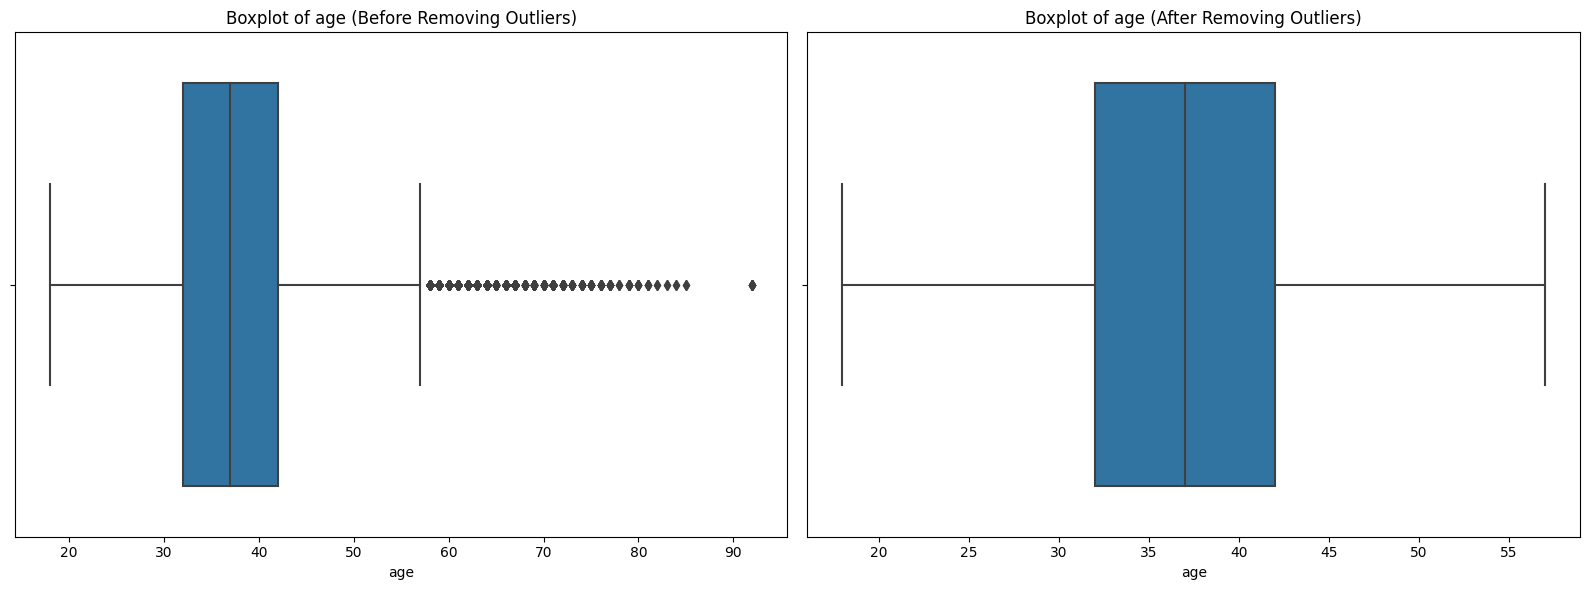

Saved plot to age_outlier_comparison.png

Processing column: acc_balance
Number of outliers found in 'acc_balance': 0


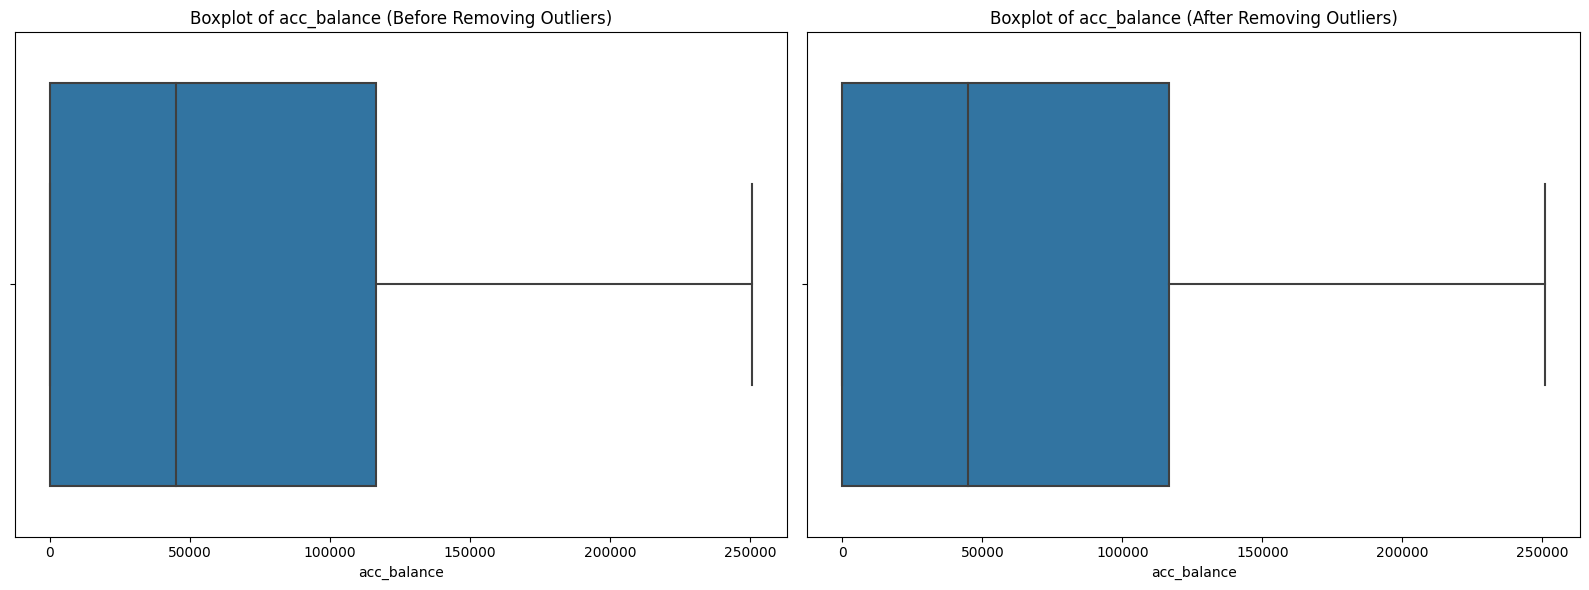

Saved plot to acc_balance_outlier_comparison.png



In [9]:
def handle_outliers(df, col):
    col_data = df[col].dropna()

    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    return outlier_indices
    
def create_outlier_boxplots(df, col):
    
    print(f"Processing column: {col}")
    
    outlier_indices = handle_outliers(df, col)
    print(f"Number of outliers found in '{col}': {len(outlier_indices)}")

    df_no_outliers = df.drop(outlier_indices)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Boxplot of {col} (Before Removing Outliers)")
    axes[0].set_xlabel(col)

    sns.boxplot(x=df_no_outliers[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col} (After Removing Outliers)")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.savefig(f"{col}_outlier_comparison.png")
    plt.show()
    print(f"Saved plot to {col}_outlier_comparison.png\n")

columns_to_visualize = ['credit_score', 'age', 'acc_balance']

for column in columns_to_visualize:
    create_outlier_boxplots(train_df.copy(), column)

# 5. Exploratory Data Analysis (EDA)

## 5.1 Customer Churn Treemap: Country → Gender → Activity → Exit Status

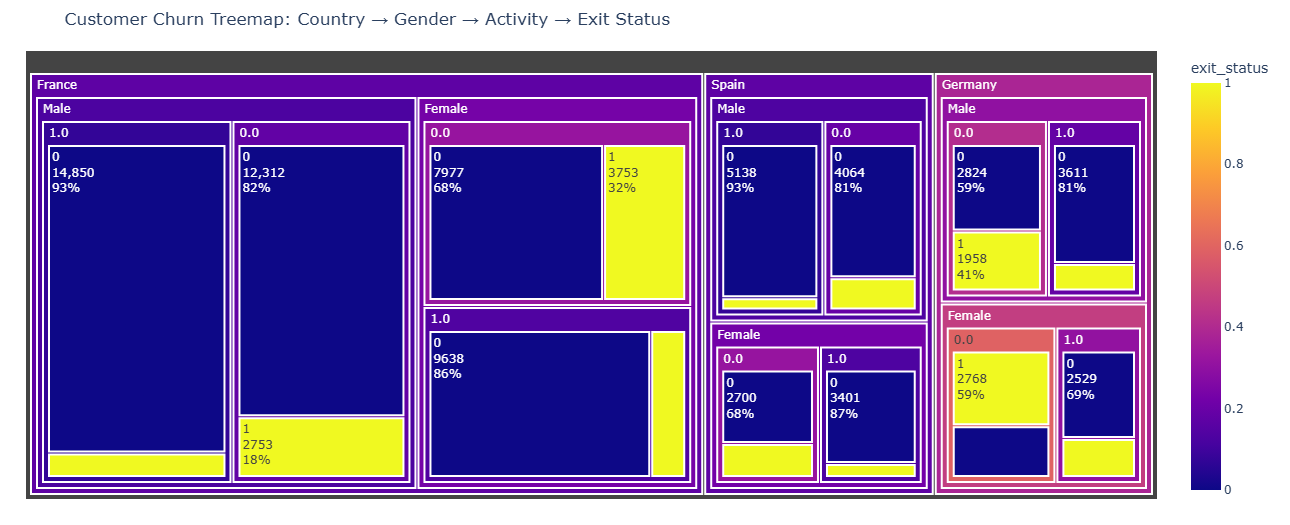

In [10]:
from IPython.display import Image, display, FileLink, HTML

custom_colors = {
    '0': '#4CAF50',
    '1': '#E74C3C'
}

fig = px.treemap(train_df, 
                 path=['country', 'gender', 'is_active', 'exit_status'], 
                 values=None, 
                 color='exit_status', 
                 color_discrete_map=custom_colors,
                 title='Customer Churn Treemap: Country → Gender → Activity → Exit Status')

fig.update_traces(root_color="lightgrey", 
                  marker=dict(line=dict(color='white', width=2)),
                  textinfo='label+percent parent+value')

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25),
                  uniformtext=dict(minsize=12, mode='hide'))


fig.write_html("treemap_interactive.html")
display(Image("/kaggle/input/plot-images/TreeMap_Plot.png"))
display(HTML('<a href="treemap_interactive.html" target="_blank">🔗 Click to View Interactive Treemap</a>'))

### Insights
1. Churn is not uniform – Certain segments like inactive customers, specific countries, and gender groups have higher churn rates, indicating customer behavioral patterns.
  
2. Segment-wise churn analysis identifies hotspots – Subgroups like "Inactive male customers from Country X" dominate the "Exit" block, guiding targeted interventions.
  
3. Feature interactions are crucial for modeling – The treemap shows that churn depends on combinations of features (e.g., country + gender + activity), suggesting tree-based models like Random Forest or XGBoost will likely perform better than linear models.
  
4. Potential for model bias due to class imbalance in subgroups – If certain customer segments have few churn cases, the model may underfit or overfit those groups, so stratified sampling and careful evaluation are necessary.
  
5. Feature importance expectation – Features like is_active, country, and gender are likely to have high importance or SHAP values post-modeling, and the treemap helps you anticipate that before training. 

## 5.2 Parallel Coordinates Plot

This plot visualizes multiple customer features simultaneously to compare patterns between customers who stay (green) and those who exit (red). Each line represents a customer, and the position of the line across each vertical axis shows the customer’s feature values (e.g., credit score, age, account balance, product count, activity status). The plot helps identify feature interactions and behavioral patterns linked to churn.

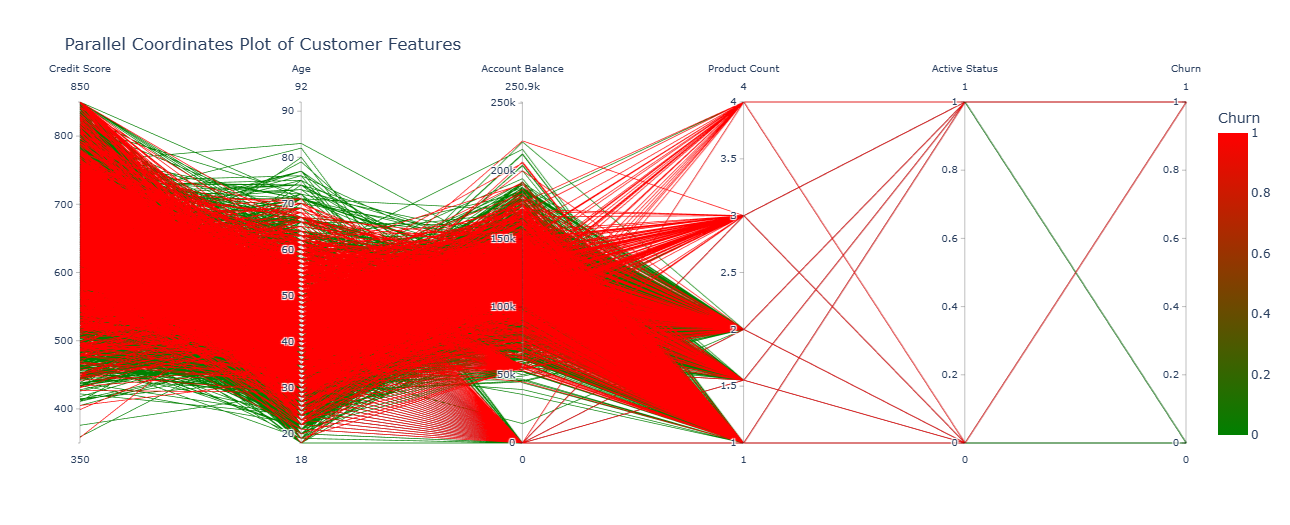

In [11]:
selected_features = ['credit_score', 'age', 'acc_balance', 'prod_count', 'is_active', 'exit_status']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df_scaled = train_df.copy()
train_df_scaled[selected_features[:-1]] = scaler.fit_transform(train_df_scaled[selected_features[:-1]])
import plotly.express as px

fig = px.parallel_coordinates(train_df[selected_features],
                               color='exit_status',
                               color_continuous_scale=['green', 'red'],
                               labels={
                                   "credit_score": "Credit Score",
                                   "age": "Age",
                                   "acc_balance": "Account Balance",
                                   "prod_count": "Product Count",
                                   "is_active": "Active Status",
                                   "exit_status": "Churn"
                               },
                               title="Parallel Coordinates Plot of Customer Features")

fig.write_html("parallel_coordinates_interactive.html")
display(Image("/kaggle/input/plot-images/Parallel_Plot.png"))
display(HTML('<a href="parallel_coordinates_interactive.html" target="_blank">🔗 Click to View Interactive Parallel Coordinates Plot</a>'))

### Insights 

1. Churners tend to have fewer products: Customers with low prod_count are more likely to exit, indicating cross-sell opportunities could improve retention.
  
2. Inactive customers are high-risk: Lines corresponding to churners cluster at the bottom of the is_active axis, suggesting inactivity is a major churn driver.
  
3. Low account balance and credit score correlate with churn: Financially less stable customers are more prone to leaving the institution.
  
4. Younger customers are more likely to churn: Churners often pass through lower age values in the plot.
  
5. Feature interactions are crucial: Churn is not driven by one variable alone; combinations of inactivity, low balance, and low product count lead to higher exit rates.
➔ Tree-based models (Random Forest, XGBoost) are better suited as they can capture such interactions naturally.
  
6. Model feature importance expectations are validated: is_active, prod_count, and acc_balance are visually confirmed as key features, which will likely dominate SHAP or feature importance analysis after model training.
    
7. This plot helps reveal complex, non-linear patterns in the data, offering insights not easily captured by looking at features individually. It provides a foundation for building models that account for feature interactions and for designing targeted customer engagement plans.


## 5.3 Donut Chart: Churn Distribution by Activity Status

This donut chart visualizes customer churn segmented by activity status. The chart helps understand how customer engagement relates to churn behavior.

The outer ring shows customers divided into:

  * Active Stay
  
  * Active Churn
  
  * Inactive Stay
  
  * Inactive Churn

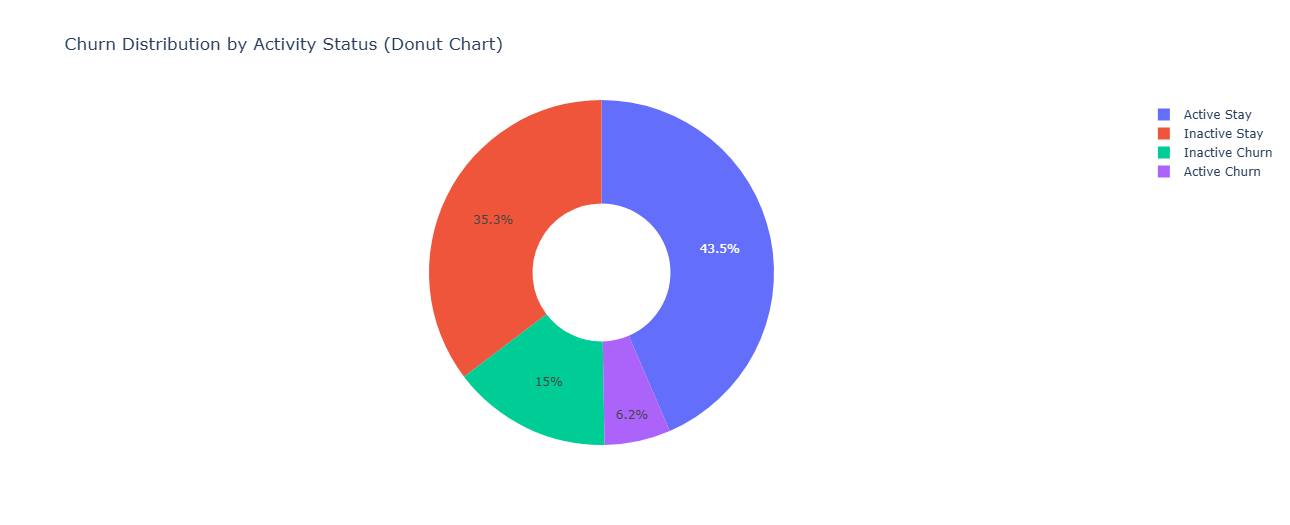

In [12]:
import plotly.graph_objects as go

labels = ['Active Stay', 'Active Churn', 'Inactive Stay', 'Inactive Churn']
values = [
    len(train_df[(train_df['is_active']==1)&(train_df['exit_status']==0)]),
    len(train_df[(train_df['is_active']==1)&(train_df['exit_status']==1)]),
    len(train_df[(train_df['is_active']==0)&(train_df['exit_status']==0)]),
    len(train_df[(train_df['is_active']==0)&(train_df['exit_status']==1)])
]

fig = go.Figure(go.Pie(labels=labels, values=values, hole=0.4))
fig.update_layout(title_text="Churn Distribution by Activity Status (Donut Chart)")

fig.write_html("donut_interactive.html")
display(Image("/kaggle/input/plot-images/Donut_Plot.png"))
display(HTML('<a href="donut_interactive.html" target="_blank">🔗 Click to View Interactive Donut Plot</a>'))


### Insights
  
1. The high churn rate among inactive users suggests is_active will be a dominant predictor in the model.
  
2. The model may over-rely on is_active, potentially ignoring other relevant patterns. Proper regularization or feature importance checks (e.g., SHAP) are needed.
  
3. The imbalance between active and inactive users could lead to biased predictions. Consider using stratified sampling, class weights, or resampling techniques.
  
4. If is_active is determined too close to churn time, it may act as a leaky feature, inflating model performance unrealistically.
  
5. You might need different thresholds or retention strategies for active vs inactive customers, which could lead to segment-wise model calibration.

# 6. Feature Scaling and Encoding

## 6.1 Feature Engineering

Creating new features using existing features, so that the model could capture the data easily.

In [13]:
# New Feature Engineering (Train & Test)
for df in [train_df, test_df]:
    df['balance_to_salary_ratio'] = df['acc_balance'] / (df['estimated_salary'] + 1)
    df['is_senior_high_balance'] = ((df['age'] > 50) & (df['acc_balance'] > 100000)).astype(int)
    df['credit_prod_interaction'] = df['credit_score'] * df['prod_count']
    
    # Convert to int first to avoid TypeError
    df['is_very_active'] = ((df['is_active'].astype(int)) & (df['has_card'].astype(int))).astype(int)
    
    df['balance_per_product'] = df['acc_balance'] / (df['prod_count'] + 1)


## 6.2 Feature Categorization

Categorizing features into categorical and numerical types to ensure it undergoes correct preprocessing treatment.

In [14]:
categorical_features = train_df.select_dtypes(include='object').columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = [col for col in categorical_features if col not in ['last_name']]
numerical_features = [col for col in numerical_features if col not in ['id', 'customer_id', 'exit_status']]

print("Final Categorical Features:", categorical_features)
print("Final Numerical Features:", numerical_features)


Final Categorical Features: ['country', 'gender']
Final Numerical Features: ['credit_score', 'age', 'tenure', 'acc_balance', 'prod_count', 'has_card', 'is_active', 'estimated_salary', 'balance_to_salary_ratio', 'is_senior_high_balance', 'credit_prod_interaction', 'is_very_active', 'balance_per_product']


## 6.3 Scaling Numerical Features and Encoding Categorical Features

Using Pipline for Scaling and Encoding of features makes it much more streamlined.

In [15]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 7. Train-Test Split

* X_train, y_train: used to train the model
  
* X_val, y_val: used to evaluate model performance
  
* random_state = 42 ensures the reproducibility of the split

In [16]:
X = train_df.drop(columns=['id', 'last_name', 'exit_status'])
y = train_df['exit_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 8. Model Building

We implement and train seven different classification models. Each model was fit using the training dataset and evaluated on the test set to gauge performance.

1. Logistic Regression
  
2. Random Forest
  
3. Decision Tree
  
4. KNN
  
5. Gradient Boosting
  
6. SVM
  
7. XGBoost

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [18]:
results = []

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:,1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "F1-Score": f1_score(y_val, y_pred)
    })

result_df = pd.DataFrame(results)
result_df.sort_values("ROC AUC", ascending=False)


,Model,Accuracy,ROC AUC,F1-Score
4,Gradient Boosting,0.859222,0.877316,0.605664
6,XGBoost,0.857111,0.871938,0.607568
1,Random Forest,0.853000,0.861501,0.594669
3,KNN,0.843000,0.813912,0.577957
0,Logistic Regression,0.827722,0.809397,0.473961
5,SVM,0.854278,0.798392,0.560268
2,Decision Tree,0.789778,0.693108,0.514124


# 9. Hyperparamter Tuning

Hyperparameter tuning is the process of finding the best combination of model settings that are defined before training and not learned from the data. In this task, we use RandomizedSearchCV to perform an exhaustive search over specified hyperparameter values for three different models to identify the optimal configuration.

## 9.1 Random Forest Classifier using RandomizedSearchCV

In [19]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_grid_rf, 
                               cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'tenure',
                                                                                'acc_balance',
                                                                                'prod_count',
                                                                                'has_card',
                                                                                'is_active',
                                                                                'estimated_salary',
                                                                                'balance_to_salary_ratio',
                                                                                'is_senior_high_balance',
                                                                                'credit_prod_interaction',
                                                                                'is_very_active',
                                                                                'balance_per_product']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['country',
                                                                                'gender'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [5, 10, None],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   scoring='roc_auc', verbose=1)

## 9.2 Gradient Boosting Classifier using RandomizedSearchCV

In [20]:
param_grid_gbm = {
    'classifier__n_estimators': [100, 150],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

pipeline_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

search_gbm = RandomizedSearchCV(pipeline_gbm, param_distributions=param_grid_gbm, 
                                cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
search_gbm.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'tenure',
                                                                                'acc_balance',
                                                                                'prod_count',
                                                                                'has_card',
                                                                                'is_active',
                                                                                'estimated_salary',
                                                                                'balance_to_salary_ratio',
                                                                                'is_senior_high_balance',
                                                                                'credit_prod_interaction',
                                                                                'is_very_active',
                                                                                'balance_per_product']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['country',
                                                                                'gender'])])),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.05, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [100, 150]},
                   scoring='roc_auc', verbose=1)

## 9.3 XGBoost using RandomizedSearchCV

In [21]:
param_grid_xgb = {
    'classifier__n_estimators': [100, 150],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

search_xgb = RandomizedSearchCV(pipeline_xgb, param_distributions=param_grid_xgb, 
                                cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'tenure',
                                                                                'acc_balance',
                                                                                'prod_count',
                                                                                'has_card',
                                                                                'is_active',
                                                                                'estimated_salary',
                                                                                'balance_to_salary_ratio',
                                                                                'is_senior_high_balance',
                                                                                'credit_prod_interaction',
                                                                                'is_very_active',
                                                                                'balance_per_product']),
                                                                              ('cat',
                                                                               One...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [100, 150],
                                        'classifier__subsample': [0.8, 1.0]},
                   scoring='roc_auc', verbose=1)

Comparing the model scores after hyperparameter tuning.

In [22]:
for name, search in zip(['Random Forest', 'Gradient Boosting', 'XGBoost'],
                        [search_rf, search_gbm, search_xgb]):
    best_model = search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    y_val_proba = best_model.predict_proba(X_val)[:,1]
    
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("F1 Score:", f1_score(y_val, y_val_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
    print("-"*30)


Model: Random Forest
Accuracy: 0.8582222222222222
F1 Score: 0.5932419509085113
ROC AUC: 0.8767751272585973
------------------------------
Model: Gradient Boosting
Accuracy: 0.86
F1 Score: 0.6096654275092936
ROC AUC: 0.8777080822434522
------------------------------
Model: XGBoost
Accuracy: 0.8594444444444445
F1 Score: 0.6066542288557213
ROC AUC: 0.8774939056234249
------------------------------


In [23]:
val_probs = search_xgb.best_estimator_.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Optimal Threshold: {best_thresh:.2f}")
print(f"Best F1 Score on Validation Set: {best_f1:.4f}")


Optimal Threshold: 0.29
Best F1 Score on Validation Set: 0.6448


# 10. Model Comparision and Evaluation

## 10.1 Model Performance Comparision Graph

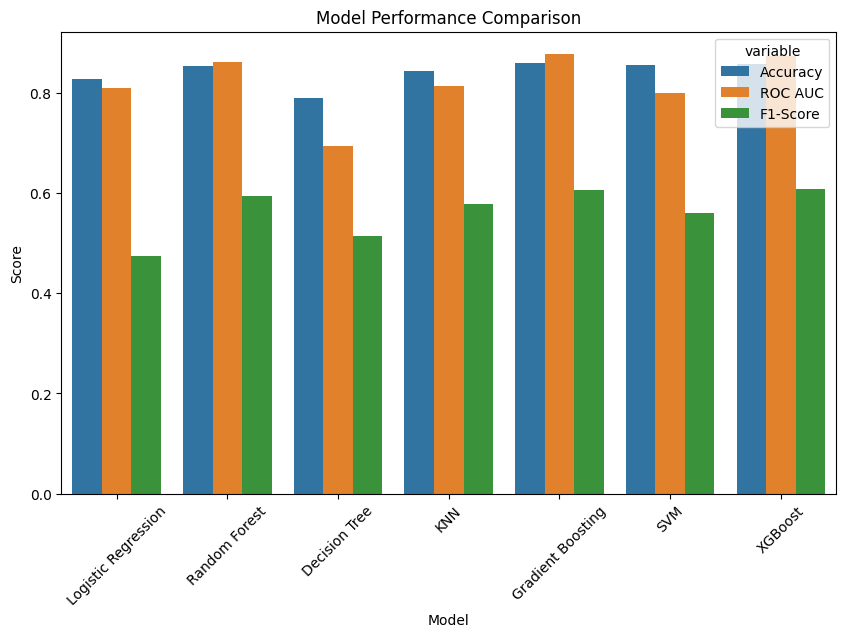

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(data=result_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


## 10.2 Updated result_df with the hyperparameter tuned model scores

In [25]:
# new tuned results
new_results = [
    ['RandomForest_Tuned', 0.8577777777777778, 0.588292055323255, 0.8761876261932179],
    ['GradientBoosting_Tuned', 0.8594444444444445, 0.6090852904820766, 0.8775948056221834],
    ['XGBoost_Tuned', 0.8592222222222222, 0.6125382262996942, 0.878272189827271]
]

new_df = pd.DataFrame(new_results, columns=['Model', 'Accuracy', 'F1-Score', 'ROC AUC'])

result_df = pd.concat([result_df, new_df], ignore_index=True)

result_df = result_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

display(result_df)

,Model,Accuracy,ROC AUC,F1-Score
0,XGBoost_Tuned,0.859222,0.878272,0.612538
1,GradientBoosting_Tuned,0.859444,0.877595,0.609085
2,Gradient Boosting,0.859222,0.877316,0.605664
3,RandomForest_Tuned,0.857778,0.876188,0.588292
4,XGBoost,0.857111,0.871938,0.607568
5,Random Forest,0.853000,0.861501,0.594669
6,KNN,0.843000,0.813912,0.577957
7,Logistic Regression,0.827722,0.809397,0.473961
8,SVM,0.854278,0.798392,0.560268
9,Decision Tree,0.789778,0.693108,0.514124


# 11. Final Model 
After evaluating and fine-tuning hyperparameters of all the models, the XGBoost Classifier Tuned has the best ROC AUC value. So, we use this optimised model on complete training set before generating final predictions.

## Threshold Tuning for XGB Pipeline

In [26]:
val_probs = search_xgb.best_estimator_.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (val_probs >= t).astype(int)) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"XGBoost Optimal Threshold: {best_thresh}, F1: {best_f1:.4f}")

XGBoost Optimal Threshold: 0.2899999999999999, F1: 0.6448


## Stacking Meta Model with threshold tuning

In [27]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('rf', search_rf.best_estimator_.named_steps['classifier']),
    ('gbm', search_gbm.best_estimator_.named_steps['classifier']),
    ('xgb', search_xgb.best_estimator_.named_steps['classifier'])
]

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=False
)

stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stack_model)
])

stack_pipe.fit(X_train, y_train)
stack_probs = stack_pipe.predict_proba(X_val)[:, 1]

# Threshold tuning for stacking
stack_f1_scores = [f1_score(y_val, (stack_probs >= t).astype(int)) for t in thresholds]
best_thresh_stack = thresholds[np.argmax(stack_f1_scores)]
best_f1_stack = np.max(stack_f1_scores)

print(f"Stacking Optimal Threshold: {best_thresh_stack}, F1: {best_f1_stack:.4f}")


Stacking Optimal Threshold: 0.3199999999999999, F1: 0.6454


## Comparing ROC-AUC Scores

In [28]:
# ROC AUC
xgb_auc = roc_auc_score(y_val, val_probs)
stack_auc = roc_auc_score(y_val, stack_probs)

print(f"Tuned XGBoost: F1={best_f1:.4f}, AUC={xgb_auc:.4f}")
print(f"Stacking: F1={best_f1_stack:.4f}, AUC={stack_auc:.4f}")


Tuned XGBoost: F1=0.6448, AUC=0.8775
Stacking: F1=0.6454, AUC=0.8780


## Test Predictions On XGB pipeline and Stacking Pipeline

In [29]:
import shutil

X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

# Test data
X_test = test_df.drop(columns=['id', 'last_name'])

# -------------- XGBoost Pipeline --------------
xgb_final = search_xgb.best_estimator_
xgb_final.fit(X_full, y_full)

xgb_test_probs = xgb_final.predict_proba(X_test)[:, 1]
xgb_final_preds = (xgb_test_probs >= best_thresh).astype(int)

submission_xgb = submission_df.copy()
submission_xgb['exit_status'] = xgb_final_preds
submission_xgb.to_csv("xgb_submission.csv", index=False)

# -------------- Stacking Pipeline --------------
stack_pipe.fit(X_full, y_full)

stack_test_probs = stack_pipe.predict_proba(X_test)[:, 1]
stack_final_preds = (stack_test_probs >= best_thresh_stack).astype(int)

submission_stack = submission_df.copy()
submission_stack['exit_status'] = stack_final_preds
submission_stack.to_csv("stacking_submission.csv", index=False)

# -------------- Pick the better model --------------
if best_f1_stack > best_f1:
    shutil.move("stacking_submission.csv", "final_submission.csv")
    print("Stacking selected for final submission.")
else:
    shutil.move("xgb_submission.csv", "final_submission.csv")
    print("XGBoost selected for final submission.")


Stacking selected for final submission.


# 12. Submission File
Format predictions according to submission structure, using the sample_submission.csv as reference.

In [30]:
from IPython.display import FileLink
FileLink("final_submission.csv")


/kaggle/working/final_submission.csv